# Заглянем глубже: деревья решений и случайные леса
**Случайные леса** - пример одного из методов *ансамблей* (ensemble), основанных на агрегировании результатов ансамбля более простых оценивателей. Несколько неожиданный результат использования подобных методов ансамблей - то, что целое в данном случае оказывается больше суммы составных частей. Результат "голосования" среди достаточного количества оценивателей может оказаться лучше результата любого из отдельных участников "голосования"!

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Движущая сила случайных лесов: деревья принятия решений
**Случайные леса** - пример обучаемого ансамбля на основе деревьев принятия решений.

*Пример двоичного дерева принятия решений:*
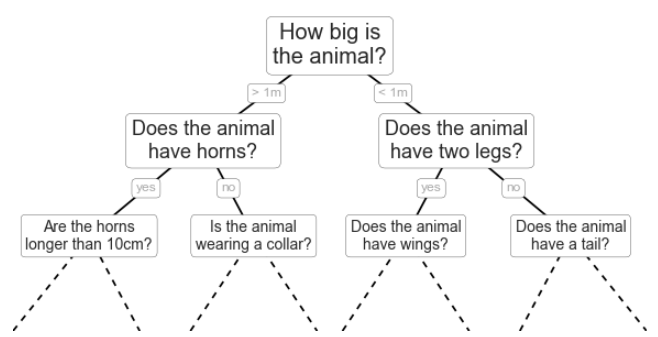
Бинарное разделение чрезвычайно эффективно: в хорошо спроектированном дереве каждый вопрос будет уменшать количество вариантов +- в двое. В связанных с машинным обучением реализациях деревьев принятия решений вопросы обычно имеют вид выровненных по осям координат разбиений данных, то есть каждый узел дерева разбивает данные на две группы с помощью порогового значения одного из признаков.
## Создание дерева принятий решений
Рассмотрим следующие двумерные данные с четырьмя возможными метками классов:

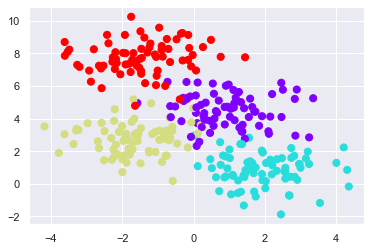

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

На рисунке приведена визуализация первых 4-х уровней классификатора для этих данных, созданного на основе дерева принятия решений:

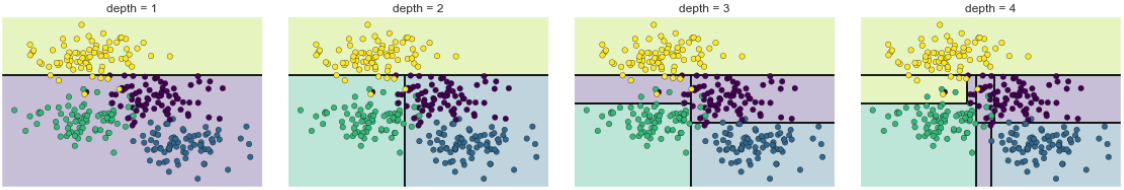

In [5]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [24]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Рисуем обучающие точки
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Обучаем оцениватель
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Создаем цветной график с результатами
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, 
                           cmap=cmap)
    
#     contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, 
#                            cmap=cmap, clim=(y.min(), y.max()), zorden=1)

    ax.set(xlim=xlim, ylim=ylim)

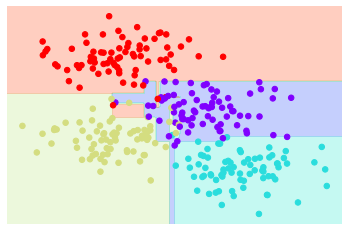

In [25]:
visualize_classifier(DecisionTreeClassifier(), X, y)

## Деревья принятия решений и переобучение
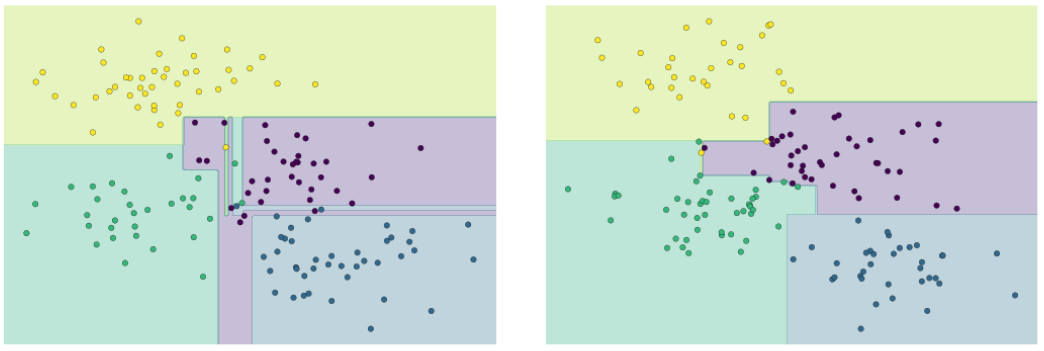

В некоторых местах результаты этих двух деревьев не противоречат друг другу, а в других местах их классификации очень сильно различаются. Вывод: расхождения имеют тенденцию появляться в тех местах, где степень достоверности классификации ниже, а значит, мы можем добиться лучшего результата, используя информацию из *обоих* (чем больше - тем будет лучше) деревьев!

## Ансамбли оценивателей: случайные леса
Идея комбинации нескольких переобученных оценивателей для снижения эффекта переобучения лежит в основе метода ансамблей под названием *"баггинг"* (bagging). Баггинг использует ансамбль (например, своеобразную "шляпу фокусника") параллельно работающих переобучаемых оценивателей и усредняет результаты для получения оптимальной классификации. Ансамбль случайных деревьев принятия решений называется *случайным лесом* (random forest).

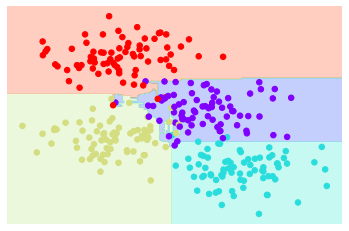

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)
bag.fit(X, y)
visualize_classifier(bag, X, y)

В этом примере мы рандомизировали данные путем обучения всех оценивателей на случайном подмножестве, состоящем из 80% обучающих точек. На практике, для более эффективной рандомизацими деревьев принятия решений обеспечивается определенная стохастичность процесса выбора разбиений. При этом всякий раз в обучении участвуют все данные, но результаты обучения все равно сохраняют требуемую случайность. 

В библиотеке Scikit-Learn подобный оптимизированный ансамбль случаайных деревьев принятия решений, автоматически выполняющий всю рандомизацию, реализован в оценивателе **RandomForestClassifier**. Все, что остается сделать - выбрать количество оценивателей и он очень быстро (при необходимости параллельно) обучит ансамбль деревьев:

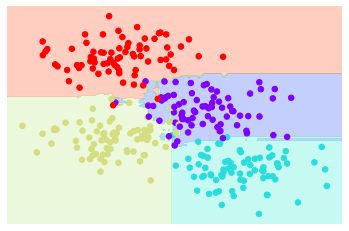

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## Регрессия с помощью случайных лесов
Полезно при непрерывных а не категориальных величинах. Рассмотрим данные, полученные из сочетания быстрых и медленных колебаний:

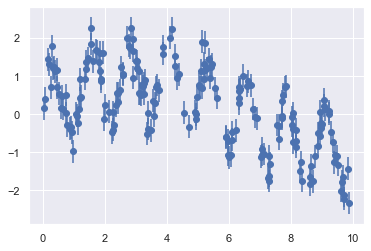

In [28]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Найти оптимальную аппроксимирующую кривую с помощью регрессии на основе случайного леса можно следующим образом:

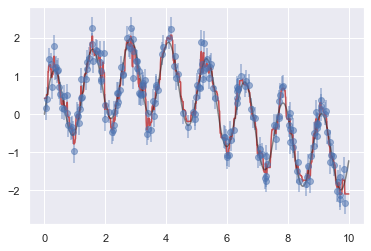

In [30]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

## Пример: использование случайного леса для классификации цифр

In [31]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

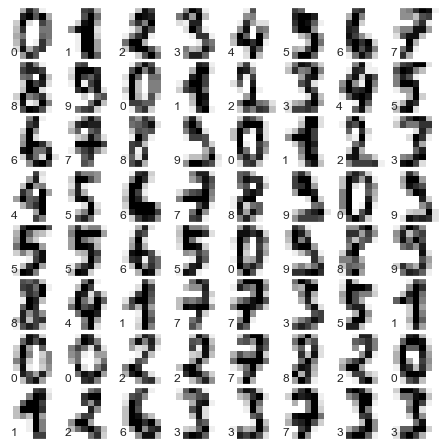

In [33]:
# Настройка рисунка
fig = plt.figure(figsize=(6, 6)) # размер рисунка в дюймах
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Рисуем цифры: размер каждого изображения 8 х 8 пикселов
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # Маркируем изображение целевыми значениями
    ax.text(0, 7, str(digits.target[i]))

Быстро классифицировать цифры с помощью случайного леса можно следующим образом:

In [36]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [37]:
# Посмотрим отчет о классификации для данного классификатора:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Text(89.18, 0.5, 'predicted label \\ прогнозируемые')

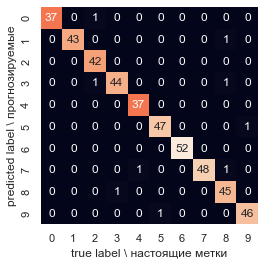

In [39]:
# И визуализируем матрицу различий:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label \ настоящие метки')
plt.ylabel('predicted label \ прогнозируемые')

## Резюме по случайным лесам
Мы познакомились с понятием *ансамблей оценивателей* и, в частности, модели случайного леса - ансамбля случайных деревьев принятия решений.

•  Как обучение, так и предсказание выполняются очень быстро в силу простоты лежащих в основе модели деревьев принятия решений. Кроме того, обе задачи допускают эффективную параллелизацию, так как отдельные деревья представляют собой совершенно независимые сущности.

• Вариант с несколькими деревьями дает возможность использования вероятностой классификации: решение путем "голосования" оценивателей дает оценку вероятности (**predict_proba()**).

• Непараметрическая модель исключительно гибка и может эффективно работать с задачами, на которых другие оцениватели оказываются недообученными.

Основной недостаток случайных лесов - результаты сложно интерпретировать. Чтобы сделать какие-либо выводы относительно *смысла* модели классификации, случайные леса - не лучший вариант.